# Logistic Active Learning

In [164]:
import numpy as np
import pandas as pd
import pickle, gc
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from mclearn import *
%matplotlib inline
plt.style.use('ggplot')
HTML(open("styles/stylesheet.css", "r").read())

## 1. Preparing the Data

In [9]:
# read in the data
sdss = pd.io.parsers.read_csv("data/sdss_dr7_photometry.csv.gz", compression="gzip")

# correct for dust extinction
dust_extinction_w14(sdss)

relevant_inputs = ['ra', 'dec', 'class', 'psfMag_i_w14', 'petroMag_i_w14', 'petroRad_r',
                   'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14', 'psf_i_z_w14',
                   'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14', 'petro_r_i_w14',
                   'petro_i_z_w14']

sdss = sdss[relevant_inputs]
gc.collect()

Let's now split the data into a training pool and a test pool.

In [12]:
colour_features = ['psfMag_i_w14', 'petroMag_i_w14', 'petroRad_r',
                   'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14', 'psf_i_z_w14',
                   'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14', 'petro_r_i_w14',
                   'petro_i_z_w14']

# 70/30 split of training and test sets
training_pool, testing_pool, training_oracle, testing_oracle = train_test_split(
    np.array(sdss[colour_features]), np.array(sdss['class']), train_size=0.7)

# shuffle the data
training_pool, training_oracle = shuffle(training_pool, training_oracle)
testing_pool, testing_oracle = shuffle(testing_pool, testing_oracle)

In [13]:
is_galaxy = testing_oracle == 'Galaxy'
is_star = testing_oracle == 'Star'
is_quasar = testing_oracle == 'Quasar'

galaxy_test = testing_pool[is_galaxy]
star_test = testing_pool[is_star]
quasar_test = testing_pool[is_quasar]

max_sub_size = len(quasar_test)
testing_pool = np.concatenate((galaxy_test[:max_sub_size],
                               star_test[:max_sub_size],
                               quasar_test[:max_sub_size]), axis=0)
testing_oracle = np.concatenate((np.repeat('Galaxy', max_sub_size),
            np.repeat('Star', max_sub_size), np.repeat('Quasar', max_sub_size)))

## 2. Experiment with Logistic Regression

In [102]:
# experiment parameters
sub_sample_size = 26500
full_sample_size = sub_sample_size * 3
total_n = 1000
initial_n = 20
random_n = full_sample_size
committee_size = 8
bag_size = 10000
n_examples = np.arange(initial_n, total_n + 1)
x = np.transpose(np.tile(n_examples, (10,1)))

In [63]:
def run_expt_with_heuristic_random(lc_heursitic, classifier, committee=None):
    """ Experiment routine with a partciular classifier heuristic. """
    
    learning_curves = []

    for i in np.arange(0, full_sample_size * 10, full_sample_size):
        training_sub_pool = training_pool[i:i+full_sample_size]
        training_sub_oracle = training_oracle[i:i+full_sample_size]
    
        # train the active learner
        learning_curve = active_learning(
            training_sub_pool, testing_pool, training_sub_oracle, testing_oracle,
            total_n=total_n, initial_n=initial_n, random_n=random_n,
            active_learning_heuristic=lc_heursitic, classifier=classifier,
            compute_accuracy=compute_accuracy, n_classes=3, committee=committee,
            bag_size=bag_size, verbose=False)
        
        learning_curves.append(learning_curve)
        print('.', end='')
    
    print('|', end='')
    return learning_curves

### 2.1. Original Sampling Pool

In [1]:
# the main classifier
logistic_classifier = LogisticRegression(random_state=2, class_weight='auto')

# the classifier committee
logistic_committee=[]
for i in range(committee_size):
    logistic_committee.append(LogisticRegression(random_state=2, class_weight='auto'))

dt_committee=[]
for i in range(committee_size):
    dt_committee.append(DecisionTreeClassifier(class_weight='auto'))
    
    
# train active learner with different heuristics
lc_logistic_random = run_expt_with_heuristic_random(ac_random, logistic_classifier)
lc_logistic_entropy = run_expt_with_heuristic_random(ac_entropy, logistic_classifier)
lc_logistic_margin = run_expt_with_heuristic_random(ac_margin, logistic_classifier)
lc_logistic_qbb_margin = run_expt_with_heuristic_random(ac_qbb_margin, logistic_classifier, committee=dt_committee)
lc_logistic_qbb_kl = run_expt_with_heuristic_random(ac_qbb_kl, logistic_classifier, committee=dt_committee)

# save experiment results to disk
with open('results/sdss_active_learning/lc_logistic_random.pickle', 'wb') as f:
    pickle.dump((lc_logistic_random, lc_logistic_entropy, lc_logistic_margin,
                lc_logistic_qbb_margin, lc_logistic_qbb_kl), f, pickle.HIGHEST_PROTOCOL)

..........|..........|..........|..........|..........|


### 2.2. Balanced Sampling Pool

In [69]:
# shuffle the data
training_pool, training_oracle = shuffle(training_pool, training_oracle)

is_galaxy = training_oracle == 'Galaxy'
is_star = training_oracle == 'Star'
is_quasar = training_oracle == 'Quasar'

galaxy_features = training_pool[is_galaxy]
star_features = training_pool[is_star]
quasar_features = training_pool[is_quasar]

In [70]:
def run_expt_with_heuristic_balanced(lc_heursitic, classifier, committee=None):
    """ Experiment routine with a partciular classifier heuristic. """
    
    learning_curves = []
    
    for i in np.arange(0, sub_sample_size * 10, sub_sample_size):
        training_galaxy = galaxy_features[i:i+sub_sample_size]
        training_star = star_features[i:i+sub_sample_size]
        training_quasar = quasar_features[i:i+sub_sample_size]
        
        training_sub_pool = np.concatenate((training_galaxy, training_star, training_quasar), axis=0)
        training_sub_oracle = np.concatenate((np.repeat('Galaxy', sub_sample_size),
            np.repeat('Star', sub_sample_size), np.repeat('Quasar', sub_sample_size)))
    
        # train the active learner
        learning_curve = active_learning(
            training_sub_pool, testing_pool, training_sub_oracle, testing_oracle,
            total_n=total_n, initial_n=initial_n, random_n=random_n,
            active_learning_heuristic=lc_heursitic, classifier=classifier,
            compute_accuracy=compute_accuracy, n_classes=3, committee=committee,
            bag_size=bag_size, verbose=False)
        
        learning_curves.append(learning_curve)
        print('.', end='')
    
    print('|', end='')
    return learning_curves

In [71]:
# the main classifier
logistic_classifier = LogisticRegression(random_state=2, class_weight='auto')

# the classifier committee
logistic_committee=[]
for i in range(committee_size):
    logistic_committee.append(LogisticRegression(random_state=2, class_weight='auto'))

# train active learner with different heuristics
lc2_logistic_random = run_expt_with_heuristic_balanced(ac_random, logistic_classifier)
lc2_logistic_entropy = run_expt_with_heuristic_balanced(ac_entropy, logistic_classifier)
lc2_logistic_margin = run_expt_with_heuristic_balanced(ac_margin, logistic_classifier)
lc2_logistic_qbb_margin = run_expt_with_heuristic_balanced(ac_qbb_margin, logistic_classifier, committee=logistic_committee)
lc2_logistic_qbb_kl = run_expt_with_heuristic_balanced(ac_qbb_kl, logistic_classifier, committee=logistic_committee)

# save experiment results to disk
with open('results/sdss_active_learning/lc_logistic_balanced.pickle', 'wb') as f:
    pickle.dump((lc2_logistic_random, lc2_logistic_entropy, lc2_logistic_margin,
                lc2_logistic_qbb_margin, lc2_logistic_qbb_kl), f, pickle.HIGHEST_PROTOCOL)

..........|..........|..........|..........|..........|

## 3. Results

#### 3.1. Logistic Regression with Original Sampling Pool

In [203]:
with open('results/sdss_active_learning/lc_logistic_random.pickle', 'rb') as f:
    lc_logistic_random, lc_logistic_entropy, lc_logistic_margin, \
                lc_logistic_qbb_margin, lc_logistic_qbb_kl = pickle.load(f)

lc_logistic_random = np.array(lc_logistic_random)
lc_logistic_entropy = np.array(lc_logistic_entropy)
lc_logistic_margin = np.array(lc_logistic_margin)
lc_logistic_qbb_margin = np.array(lc_logistic_qbb_margin)
lc_logistic_qbb_kl = np.array(lc_logistic_qbb_kl)

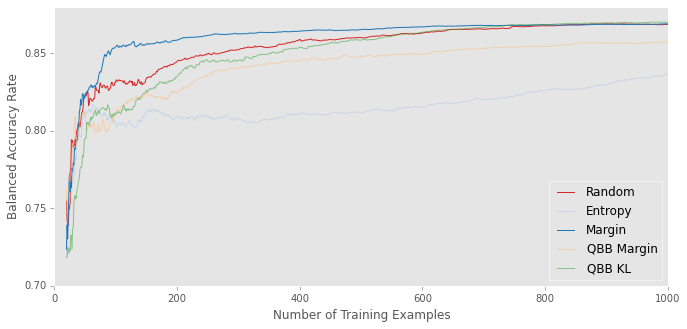

In [206]:
m_random = np.zeros(len(x))
m_entropy = np.zeros(len(x))
m_margin = np.zeros(len(x))
m_qbb_margin = np.zeros(len(x))
m_logistic_qbb_kl = np.zeros(len(x))

for i in range(len(x)):
    m_random[i] = np.mean(lc_logistic_random[:,i])
    m_entropy[i] = np.mean(lc_logistic_entropy[:,i])
    m_margin[i] = np.mean(lc_logistic_margin[:,i])
    m_qbb_margin[i] = np.mean(lc_logistic_qbb_margin[:,i])
    m_logistic_qbb_kl[i] = np.mean(lc_logistic_qbb_kl[:,i])

fig1 = plt.figure(figsize=(11, 5))
ax1a = fig1.add_subplot(111)
ax1a.plot(x[:,0], m_random, color=tableau20[6], label='Random')
ax1a.plot(x[:,0], m_entropy, color=tableau20[1], label='Entropy', alpha=0.5)
ax1a.plot(x[:,0], m_margin, color=tableau20[0], label='Margin')
ax1a.plot(x[:,0], m_qbb_margin, color=tableau20[3], label='QBB Margin', alpha=0.5)
ax1a.plot(x[:,0], m_logistic_qbb_kl, color=tableau20[4], label='QBB KL', alpha=0.5)
ax1a.set_xlabel('Number of Training Examples')
ax1a.set_ylabel('Balanced Accuracy Rate')
ax1a.legend(loc='lower right')
#ax1a.set_title('Learning Curves with Logistic Regression')
ax1a.tick_params(top='off', right='off')
ax1a.grid(False)
fig1.savefig('reports/source/seminar_2_midterm/images/active_logistic_random.pdf', bbox_inches='tight')
plt.show()

#### 3.2. Logistic Regression with Balanced Sampling Pool

In [207]:
with open('results/sdss_active_learning/lc_logistic_balanced.pickle', 'rb') as f:
    lc2_logistic_random, lc2_logistic_entropy, lc2_logistic_margin, \
                lc2_logistic_qbb_margin, lc2_logistic_qbb_kl = pickle.load(f)

lc2_logistic_random = np.array(lc2_logistic_random)
lc2_logistic_entropy = np.array(lc2_logistic_entropy)
lc2_logistic_margin = np.array(lc2_logistic_margin)
lc2_logistic_qbb_margin = np.array(lc2_logistic_qbb_margin)
lc2_logistic_qbb_kl = np.array(lc2_logistic_qbb_kl)

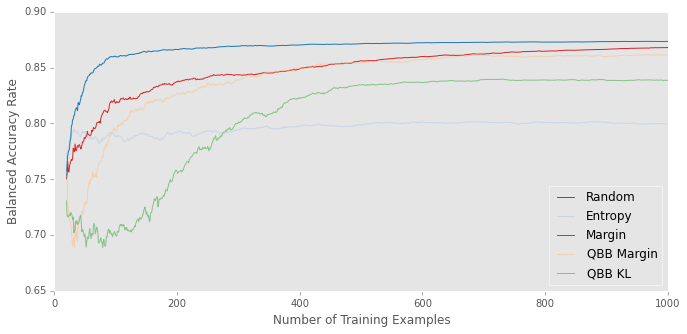

In [208]:
m_random = np.zeros(len(x))
m_entropy = np.zeros(len(x))
m_margin = np.zeros(len(x))
m_qbb_margin = np.zeros(len(x))
m_logistic_qbb_kl = np.zeros(len(x))

for i in range(len(x)):
    m_random[i] = np.mean(lc2_logistic_random[:,i])
    m_entropy[i] = np.mean(lc2_logistic_entropy[:,i])
    m_margin[i] = np.mean(lc2_logistic_margin[:,i])
    m_qbb_margin[i] = np.mean(lc2_logistic_qbb_margin[:,i])
    m_logistic_qbb_kl[i] = np.mean(lc2_logistic_qbb_kl[:,i])

fig1 = plt.figure(figsize=(11, 5))
ax1a = fig1.add_subplot(111)
ax1a.plot(x[:,0], m_random, color=tableau20[6], label='Random')
ax1a.plot(x[:,0], m_entropy, color=tableau20[1], label='Entropy', alpha=0.5)
ax1a.plot(x[:,0], m_margin, color=tableau20[0], label='Margin')
ax1a.plot(x[:,0], m_qbb_margin, color=tableau20[3], label='QBB Margin', alpha=0.5)
ax1a.plot(x[:,0], m_logistic_qbb_kl, color=tableau20[4], label='QBB KL', alpha=0.5)
ax1a.set_xlabel('Number of Training Examples')
ax1a.set_ylabel('Balanced Accuracy Rate')
ax1a.legend(loc='lower right')
#ax1a.set_title('Learning Curves with Logistic Regression')
ax1a.tick_params(top='off', right='off')
ax1a.grid(False)
fig1.savefig('reports/source/seminar_2_midterm/images/active_logistic_balanced.pdf', bbox_inches='tight')
plt.show()